In [1]:
import pandas as pd

data = pd.read_csv('/Users/anukulchandra/python with machine learning /Quora Question pair/questions.csv')

In [39]:
import numpy as np
import pandas as pd
import sklearn

print("numpy", np.__version__)
print("pandas", pd.__version__)
print("sklearn", sklearn.__version__)


numpy 1.26.4
pandas 2.1.4
sklearn 1.6.1


In [2]:
df =data[0:20000]

In [3]:
df_pos = df[df['is_duplicate']==1]
df_neg = df[df['is_duplicate']==0]

In [4]:
df = pd.concat([df_pos[0:7500],df_neg[0:7500]],axis=0)

In [5]:
df

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
...,...,...,...,...,...,...
11938,11938,23836,23837,How is knav & co Mumbai & gm kapadia Mumbai fo...,How are hamsters and gerbils able to live toge...,0
11939,11939,23838,23839,What are the applications of functional analys...,"If aliens come to destroy all of mankind, do y...",0
11940,11940,23840,23841,"What is the meaning of PQWL, RLWL, GNWL, RLGN,...",Up to what no. can the waiting list be cleared...,0
11945,11945,23850,23851,What is one thing you caught your child doing ...,What are some private things you have caught p...,0


In [6]:
def text_processing_quora_separate(data):
    from bs4 import BeautifulSoup
    import re
    from nltk.corpus import stopwords
    from tqdm import tqdm
    from nltk.stem import PorterStemmer

    def decontracted(phrase):
        # specific
        phrase = re.sub(r"<br /><br />", " ", phrase)
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can't", "can not", phrase)
        # general
        phrase = re.sub(r"n't", " not", phrase)
        phrase = re.sub(r"'re", " are", phrase)
        phrase = re.sub(r"'s", " is", phrase)
        phrase = re.sub(r"'d", " would", phrase)
        phrase = re.sub(r"'ll", " will", phrase)
        phrase = re.sub(r"'t", " not", phrase)
        phrase = re.sub(r"'ve", " have", phrase)
        phrase = re.sub(r"'m", " am", phrase)
        phrase = re.sub(r"'", " ", phrase)
        return phrase

    stopwords_set = set(stopwords.words("english"))

    preprocessed_question1 = []
    preprocessed_question2 = []
    porter = PorterStemmer()

    # tqdm is for printing the status bar
    for row in tqdm(data.itertuples(), total=len(data), desc="Processing Quora Data"):
        q1 = row.question1
        q2 = row.question2

        # Process question1
        processed_q1 = re.sub(r"http\S+", "", q1)
        processed_q1 = decontracted(processed_q1)
        processed_q1 = re.sub(r"\W", " ", processed_q1)
        processed_q1 = " ".join(word.lower() for word in processed_q1.split() if word not in stopwords_set)
        stemmed_words_q1 = [porter.stem(word) for word in processed_q1.split()]
        preprocessed_question1.append(" ".join(stemmed_words_q1))

        # Process question2
        processed_q2 = re.sub(r"http\S+", "", q2)
        processed_q2 = decontracted(processed_q2)
        processed_q2 = re.sub(r"\W", " ", processed_q2)
        processed_q2 = " ".join(word.lower() for word in processed_q2.split() if word not in stopwords_set)
        stemmed_words_q2 = [porter.stem(word) for word in processed_q2.split()]
        preprocessed_question2.append(" ".join(stemmed_words_q2))

    return preprocessed_question1, preprocessed_question2


In [7]:
# Preprocess the questions separately
preprocessed_q1, preprocessed_q2 = text_processing_quora_separate(df)

# Replace the original columns with the preprocessed versions
df["question1"] = preprocessed_q1
df["question2"] = preprocessed_q2

df.head()


Processing Quora Data: 100%|██████████| 14975/14975 [00:02<00:00, 5615.89it/s]


,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,astrolog i capricorn sun cap moon cap rise say,i tripl capricorn sun moon ascend capricorn wh...,1
7,7,15,16,how i good geologist,what i great geologist,1
11,11,23,24,how i read find youtub comment,how i see youtub comment,1
12,12,25,26,what make physic easi learn,how make physic easi learn,1
13,13,27,28,what first sexual experi like,what first sexual experi,1


In [8]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

<Axes: title={'center': 'Distribution of Duplicate Questions'}, xlabel='is_duplicate'>

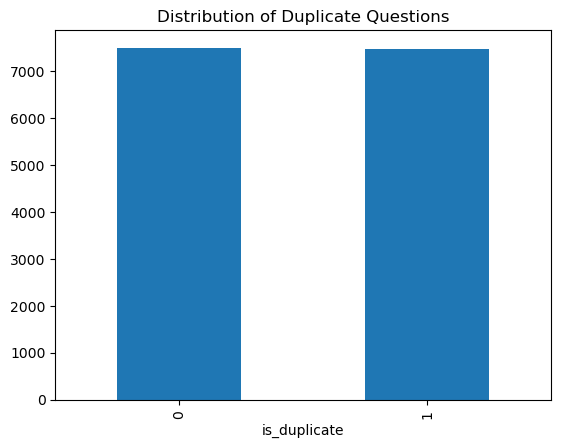

In [9]:
df['is_duplicate'].value_counts().plot(kind='bar', title='Distribution of Duplicate Questions')

# check for the Repeated question

Number of unique questions:  29896
Number of repeated questions:  53


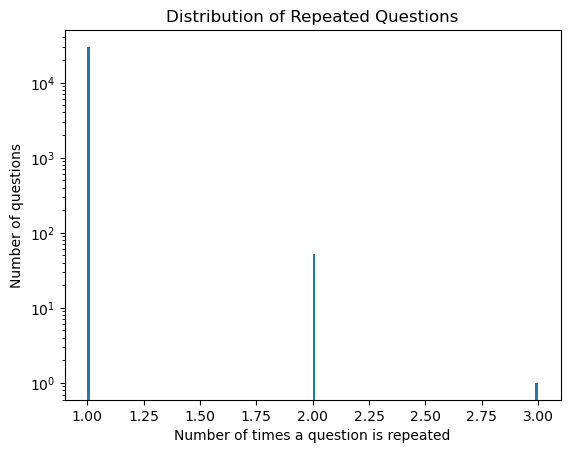

In [10]:
import numpy as np
qid=pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print("Number of unique questions: ", np.unique(qid).shape[0])

x = qid.value_counts()>1
print("Number of repeated questions: ", x[x].shape[0])
import matplotlib.pyplot as plt

plt.hist(qid.value_counts(), bins=160)
plt.yscale('log')
plt.xlabel('Number of times a question is repeated')
plt.ylabel('Number of questions')
plt.title('Distribution of Repeated Questions')
plt.show()


# Feature Engineering

## 1.Queston Length

In [11]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
5,5,11,12,astrolog i capricorn sun cap moon cap rise say,i tripl capricorn sun moon ascend capricorn wh...,1,46,52
7,7,15,16,how i good geologist,what i great geologist,1,20,22
11,11,23,24,how i read find youtub comment,how i see youtub comment,1,30,24
12,12,25,26,what make physic easi learn,how make physic easi learn,1,27,26
13,13,27,28,what first sexual experi like,what first sexual experi,1,29,24


## 2. Number of Words

In [12]:
df['q1_word_count'] = df['question1'].str.split().str.len()
df['q2_word_count'] = df['question2'].str.split().str.len()
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count
5,5,11,12,astrolog i capricorn sun cap moon cap rise say,i tripl capricorn sun moon ascend capricorn wh...,1,46,52,9,9
7,7,15,16,how i good geologist,what i great geologist,1,20,22,4,4
11,11,23,24,how i read find youtub comment,how i see youtub comment,1,30,24,6,5
12,12,25,26,what make physic easi learn,how make physic easi learn,1,27,26,5,5
13,13,27,28,what first sexual experi like,what first sexual experi,1,29,24,5,4


## 3.common word count  

In [13]:
def common_word_count(x):
    q1_words = set(map(lambda word: word.lower(), x['question1'].split(" ")))
    q2_words = set(map(lambda word: word.lower(), x['question2'].split(" ")))
    return len(q1_words & q2_words)

df['common_word_count'] = df.apply(common_word_count, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count,common_word_count
5,5,11,12,astrolog i capricorn sun cap moon cap rise say,i tripl capricorn sun moon ascend capricorn wh...,1,46,52,9,9,5
7,7,15,16,how i good geologist,what i great geologist,1,20,22,4,4,2
11,11,23,24,how i read find youtub comment,how i see youtub comment,1,30,24,6,5,4
12,12,25,26,what make physic easi learn,how make physic easi learn,1,27,26,5,5,4
13,13,27,28,what first sexual experi like,what first sexual experi,1,29,24,5,4,4


## 3.  total words

In [14]:
def calculate_total_words(row):
    q1_words = set(map(lambda word: word.lower(), row['question1'].split(" ")))
    q2_words = set(map(lambda word: word.lower(), row['question2'].split(" ")))
    return len(q1_words) + len(q2_words)

df['total_words'] = df.apply(calculate_total_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count,common_word_count,total_words
5,5,11,12,astrolog i capricorn sun cap moon cap rise say,i tripl capricorn sun moon ascend capricorn wh...,1,46,52,9,9,5,16
7,7,15,16,how i good geologist,what i great geologist,1,20,22,4,4,2,8
11,11,23,24,how i read find youtub comment,how i see youtub comment,1,30,24,6,5,4,11
12,12,25,26,what make physic easi learn,how make physic easi learn,1,27,26,5,5,4,10
13,13,27,28,what first sexual experi like,what first sexual experi,1,29,24,5,4,4,9


## 5.word shared 

In [15]:
df['word_shared'] = round(df['common_word_count'] / df['total_words'], 2)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count,common_word_count,total_words,word_shared
5,5,11,12,astrolog i capricorn sun cap moon cap rise say,i tripl capricorn sun moon ascend capricorn wh...,1,46,52,9,9,5,16,0.31
7,7,15,16,how i good geologist,what i great geologist,1,20,22,4,4,2,8,0.25
11,11,23,24,how i read find youtub comment,how i see youtub comment,1,30,24,6,5,4,11,0.36
12,12,25,26,what make physic easi learn,how make physic easi learn,1,27,26,5,5,4,10,0.40
13,13,27,28,what first sexual experi like,what first sexual experi,1,29,24,5,4,4,9,0.44


# exploratory daat analysis for newly added Features

### 1.Distribution of Question

q1: __________________
			minimum: 0
			maximum: 253
			average num of characters: 37


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


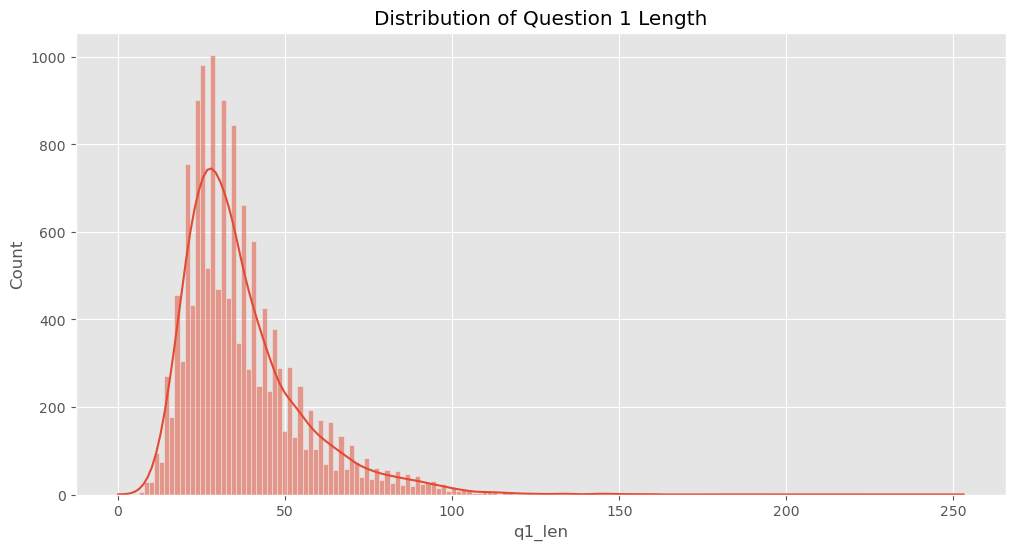

In [16]:
print('q1: __________________')
print('\t\t\tminimum:', df['q1_len'].min())
print('\t\t\tmaximum:', df['q1_len'].max())
print('\t\t\taverage num of characters:', int(df['q1_len'].mean()))

import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
sns.histplot(df['q1_len'], kde=True)
plt.title('Distribution of Question 1 Length')
plt.show()

q2: __________________
			minimum: 4
			maximum: 658
			average num of characters: 37


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


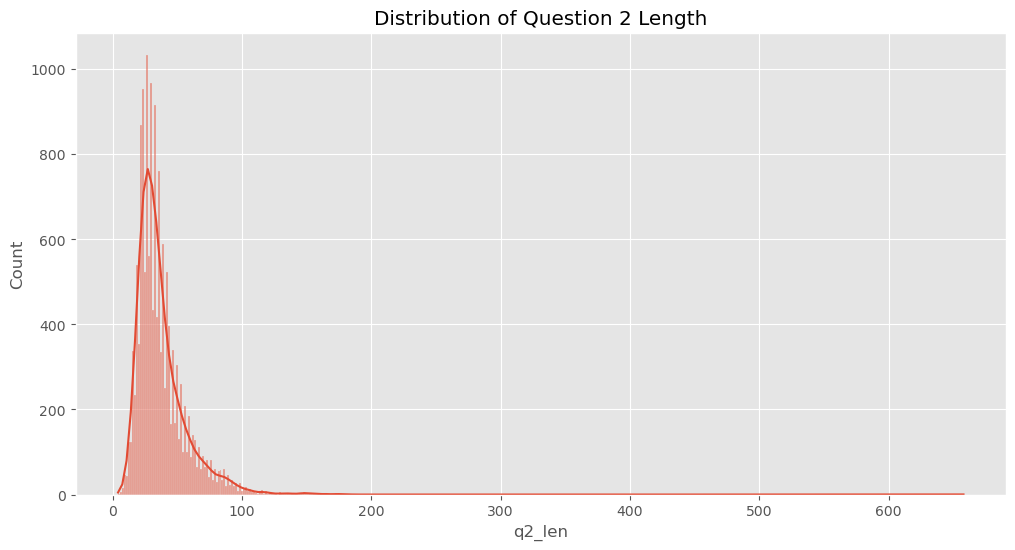

In [17]:
print('q2: __________________')
print('\t\t\tminimum:', df['q2_len'].min())
print('\t\t\tmaximum:', df['q2_len'].max())
print('\t\t\taverage num of characters:', int(df['q2_len'].mean()))

import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
sns.histplot(df['q2_len'], kde=True)
plt.title('Distribution of Question 2 Length')
plt.show()

### 3. common word distribtion


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


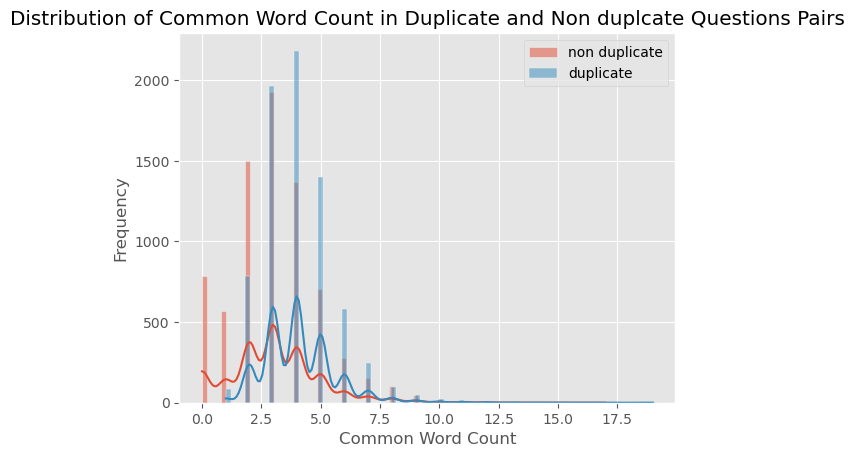

In [18]:
sns.histplot(df[df['is_duplicate']==0]['common_word_count'],label='non duplicate' ,kde=True)
sns.histplot(df[df['is_duplicate']==1]['common_word_count'],label='duplicate' ,kde=True)
plt.legend()
plt.title('Distribution of Common Word Count in Duplicate and Non duplcate Questions Pairs')
plt.xlabel('Common Word Count')
plt.ylabel('Frequency')
plt.show()

### total words aanalyssis

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


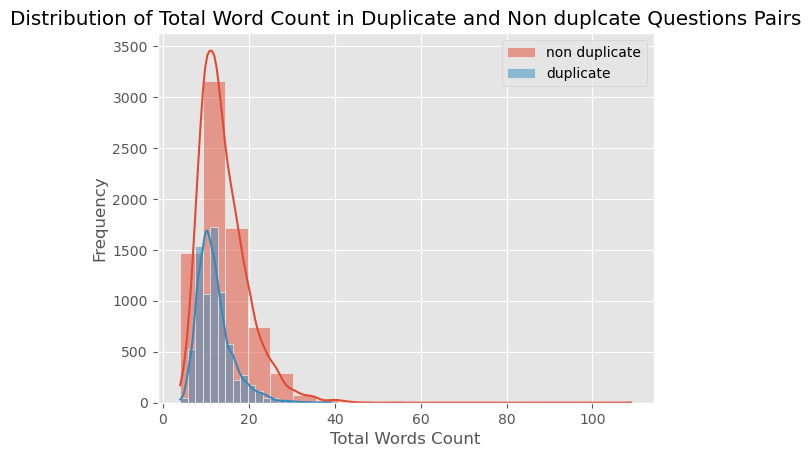

In [19]:
sns.histplot(df[df['is_duplicate']==0]['total_words'],label='non duplicate' ,kde=True,bins=20)
sns.histplot(df[df['is_duplicate']==1]['total_words'],label='duplicate' ,kde=True,bins=20)
plt.legend()
plt.title('Distribution of Total Word Count in Duplicate and Non duplcate Questions Pairs')
plt.xlabel('Total Words Count')
plt.ylabel('Frequency')
plt.show()

### word Share Analysis

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


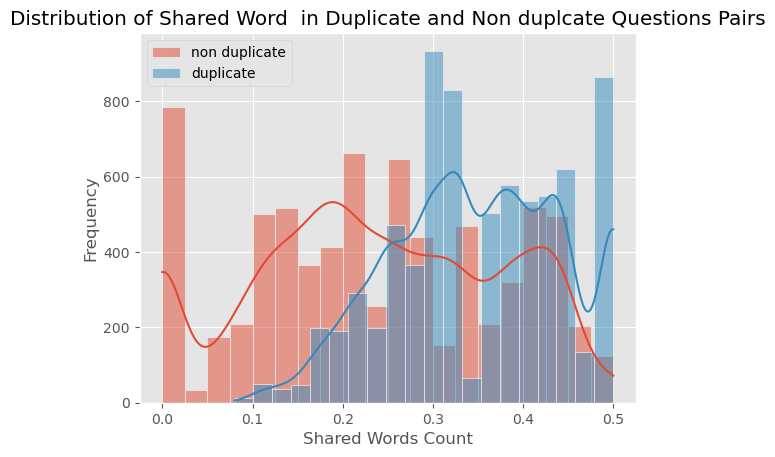

In [20]:
sns.histplot(df[df['is_duplicate']==0]['word_shared'],label='non duplicate' ,kde=True,bins=20)
sns.histplot(df[df['is_duplicate']==1]['word_shared'],label='duplicate' ,kde=True,bins=20)
plt.legend()
plt.title('Distribution of Shared Word  in Duplicate and Non duplcate Questions Pairs')
plt.xlabel('Shared Words Count')
plt.ylabel('Frequency')
plt.show()

## Machine learning Model

In [21]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
5,astrolog i capricorn sun cap moon cap rise say,i tripl capricorn sun moon ascend capricorn wh...
7,how i good geologist,what i great geologist
11,how i read find youtub comment,how i see youtub comment
12,what make physic easi learn,how make physic easi learn
13,what first sexual experi like,what first sexual experi


In [22]:
final_df =df.drop(['id','qid1','qid2', 'question1', 'question2'],axis=1)

final_df.shape
final_df.head()


,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count,common_word_count,total_words,word_shared
5,1,46,52,9,9,5,16,0.31
7,1,20,22,4,4,2,8,0.25
11,1,30,24,6,5,4,11,0.36
12,1,27,26,5,5,4,10,0.40
13,1,29,24,5,4,4,9,0.44


### vectorize the feature 

In [23]:
# ### vectorize the feature

from sklearn.feature_extraction.text import TfidfVectorizer
questions = list(ques_df['question1']) + list(ques_df['question2'])

vectorizer = TfidfVectorizer(max_features=3000)
q1_arr,q2_arr = np.vsplit(vectorizer.fit_transform(questions).toarray(),2) 


temp1 =pd.DataFrame(q1_arr, index=ques_df.index)
temp2 =pd.DataFrame(q2_arr, index=ques_df.index)

temp = pd.concat([temp1, temp2], axis=1)

temp.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.549428,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [24]:
# from sklearn.preprocessing import MinMaxScaler
# import joblib
# scaler = MinMaxScaler()


# feature_to_scale = final_df.columns[1:]
# final_df[feature_to_scale] = scaler.fit_transform(final_df[feature_to_scale])
# print(final_df.shape)
# joblib.dump(scaler, 'scaler.pkl')
# final_df.head()

feature_to_scale = [
    'q1_len',
    'q2_len',
    'q1_word_count',
    'q2_word_count',
    'common_word_count',
    'total_words',
    'word_shared'
]

from sklearn.preprocessing import MinMaxScaler
import joblib

scaler = MinMaxScaler()
final_df[feature_to_scale] = scaler.fit_transform(final_df[feature_to_scale])
joblib.dump(scaler, 'scaler.pkl')



['scaler.pkl']

In [25]:
final_df = pd.concat([final_df, temp], axis=1)
print(final_df.shape)
final_df.head()

(14975, 6008)


,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count,common_word_count,total_words,word_shared,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
5,1,0.181818,0.073394,0.191489,0.062016,0.263158,0.114286,0.62,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7,1,0.079051,0.027523,0.085106,0.023256,0.105263,0.038095,0.50,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
11,1,0.118577,0.030581,0.127660,0.031008,0.210526,0.066667,0.72,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.549428,0.0,0.0,0.0,0.0
12,1,0.106719,0.033639,0.106383,0.031008,0.210526,0.057143,0.80,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
13,1,0.114625,0.030581,0.106383,0.023256,0.210526,0.047619,0.88,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


### train test split 


In [26]:
x = final_df.iloc[:, 1:].values
y = final_df.iloc[:, 0].values

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [28]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_depth=None)
model.fit(x_train, y_train)


RandomForestClassifier(min_samples_split=5)

In [29]:
y_pred_training = model.predict(x_train)
y_pred_test = model.predict(x_test)

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Training Accuracy:", accuracy_score(y_train, y_pred_training))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))

print("\nConfusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_pred_test))

Training Accuracy: 0.9992487479131886
Test Accuracy: 0.771619365609349

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.82      0.70      0.76      1510
           1       0.73      0.84      0.79      1485

    accuracy                           0.77      2995
   macro avg       0.78      0.77      0.77      2995
weighted avg       0.78      0.77      0.77      2995


Confusion Matrix (Test Data):
[[1057  453]
 [ 231 1254]]


In [31]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=1,
    max_depth=None,
    random_state=42
)

model.fit(x_train, y_train)
y_pred_training = model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_pred_training)
print("Training Accuracy:", train_accuracy)


y_pred_test = model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.9986644407345576
Test Accuracy: 0.773288814691152


In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return [text_processing_quora_separate(doc) for doc in X]


In [33]:

import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
# Save model and vectorizer
joblib.dump(model, "quora_model.pkl")
joblib.dump(vectorizer, "cv.pkl")
#joblib.dump(scaler,'scaler.pkl')

['cv.pkl']

In [34]:
# import pandas as pd
# import numpy as np
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# from sklearn.pipeline import Pipeline


# class QuoraTextCleaner(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         if isinstance(X, np.ndarray):
#             if X.shape[1] == 2:
#                 X = pd.DataFrame(X, columns=['question1', 'question2'])
#             else:
#                 raise ValueError(f"Expected ndarray with 2 columns, got shape {X.shape}")
#         elif isinstance(X, pd.DataFrame):
#             if not set(['question1', 'question2']).issubset(X.columns):
#                 raise ValueError("DataFrame must have columns: 'question1', 'question2'")
#         else:
#             raise TypeError("Input must be DataFrame or ndarray with 2 columns")

#         q1, q2 = text_processing_quora_separate(X)
#         combined = [q1[i] + " " + q2[i] for i in range(len(q1))]
#         return combined

# # -------------------------------------------------------------------
# # Pipeline definition
# # -------------------------------------------------------------------
# pipeline = Pipeline([
#     ('cleaner', QuoraTextCleaner()),
#     ('vectorizer', CountVectorizer(max_features=1000)),
#     ('classifier', VotingClassifier(
#         estimators=[
#             ('lr', LogisticRegression(
#                 penalty='l2', C=10, class_weight='balanced',
#                 random_state=1, solver='lbfgs', n_jobs=-1)),
#             ('rf', RandomForestClassifier(
#                 n_estimators=100, min_samples_split=5,
#                 min_samples_leaf=1, max_depth=None)),
#             ('dct', DecisionTreeClassifier(
#                 criterion='gini', max_depth=None, min_samples_split=2,
#                 min_samples_leaf=1, random_state=1)),
#             ('xgb', XGBClassifier(
#                 n_estimators=100, learning_rate=0.1, max_depth=3,
#                 random_state=42, use_label_encoder=False,
#                 eval_metric='mlogloss')),
#         ],
#         voting='hard'
#     ))
# ])

# pipeline.fit(x_train, y_train)

In [35]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier

# pipeline = Pipeline([
#     ('cleaner', TextCleaner()),

#     ('vectorizer', CountVectorizer(max_features=3000)),

#     ('classifier', VotingClassifier(
#         estimators=[
#             ('lr', LogisticRegression(
#                 penalty='l2',C=10,class_weight='balanced',random_state=1,solver='lbfgs',n_jobs=-1)),
#             ('rf', RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_depth=None)),
#             ('dct', DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=1)),
#             ('xgb', XGBClassifier(
#                 n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False)),
           

#         ],
#         voting='hard'))

# ])
# pipeline.fit(x_train,y_train)

In [36]:
# xgboost installation
!pip install xgboost

In [37]:

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 8],
#     'min_samples_leaf': [1, 2, 4]
# }

# # RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=RandomForestClassifier(random_state=42),
#     param_distributions=param_grid,
#     n_iter=15,             # মোট কম্বিনেশন থেকে এলোমেলোভাবে 15 টা নেবে
#     scoring='accuracy',
#     n_jobs=-1,             # সব CPU core ব্যবহার
#     cv=3,                  # cross-validation fold কমানো
#     verbose=2,             # progress দেখতে
#     random_state=42
# )

# # ফিট করা
# random_search.fit(x_train, y_train)

# # সেরা মডেল
# best_params = random_search.best_params_
# best_clf = random_search.best_estimator_

# # টেস্ট প্রেডিকশন
# y_pred_test_best = best_clf.predict(x_test)
# accuracy_best = accuracy_score(y_test, y_pred_test_best)

# # ফলাফল দেখানো
# print("Best Parameters:", best_params)
# print("Best Test Accuracy:", accuracy_best)

# print("\nClassification Report (Test Data with Best Model):")
# print(classification_report(y_test, y_pred_test_best))

# print("\nConfusion Matrix (Test Data with Best Model):")


